# Covid-19: From model prediction to model predictive control

## JPGMs tryout of the QALY calculation

*Original code by Juan Pablo Gallo. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by BIOMATH, Ghent University. All Rights Reserved.

In `src/covid19model/models.py`, two national-level extended SEIRD compartmental models are coded,
1. COVID19_SEIRD: a deterministic model, using ordinary differential equations (ODEs). The equations are integrated using Scipy's `odeint` with a variable timestep, it is a 'continuous-time' model.
2. COVID19_SEIRD_sto: a stochastic model, using stochastic difference equations (SDEs). The equations are iterated using a fixed timestep of one day and is said to be a 'discrete-time' model.

The deterministic model was used for all results detailed in our first COVID-19 related preprint: *A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*, which can be found here: https://www.medrxiv.org/content/10.1101/2020.07.17.20156034v2

The documentation given in this tutorial has been redrafted from the above preprint. References have been omitted for the sake of simplicity.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
import pandas as pd
import datetime
import scipy
import json
import random

Load the covid 19 custom development code

In [2]:
from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.data import google, sciensano, model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

In [3]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

## Model initialization

In [4]:
# Load the interaction matrices (size: 9x9)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices()
# Define the number of age categories
levels = initN.size

In [5]:
# Define the compliance and lockdown function
def lockdown_func(t,param,policy_time,policy1,policy2,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return policy1 + (prevention*policy2-policy1)/l*(t-policy_time-tau)
    else:
        return prevention*policy2

In [28]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
# Add the delayed ramp parameters and policy changes during lockdown to model parameters dictionary
params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy_time': 53,
              'l': 1,
              'tau': 5,
              'prevention': 0.5})
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}

### QALY calculations

In [29]:
# Obtain the number of QALYs that would be lost if a person of a given age dies
from covid19model.models.QALY import get_QALY_parameters

#### Quality of life parameters

In [30]:
#Standarized Mortality ratio. It is used to adjust for increased mortality
#due to comorbidities. It modifies l(x), the term in life tables that \n
#corresponds to the number of people per 100000 hab that survives to age x
SMR=1

#Adjustment paramter to account for additional impact on quality of life 
#due to comorbidity
qCM=1

#Disccount rate. It is included due to the time preference. Things in the present
#are valued more than in the future. 5% is standard practice
r=0.05

##Import input data##
#Belgian life table information
#x: Age
#q_x: Probability that someone aged exactly x will die before reaching age x+1
input_life_table=pd.read_csv('../../data/interim/QALYs/Life_table_Belgium_2019.csv',sep=';')


#Belgian EQ-5D QoL Survey data
input_QoL=pd.read_csv('../../data/interim/QALYs/QoL_scores_Belgium_2018_v3.csv',sep=';')

#Calculate and output age-stratified parameters
lost_QALY_pp=get_QALY_parameters(input_life_table,input_QoL,SMR,qCM,r)

#Update parameters dict
params.update({'lost_QALY_pp': lost_QALY_pp})

In [31]:
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_func})

In [32]:
# Load the dictionary containing the posterior parameter distributions obtained from calibrating the model to Belgian hospitalization data
with open('../../data/interim/model_parameters/deterministic_22072020.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
model.parameters['tau'] = np.mean(samples_dict['tau'])
prevention = np.mean(samples_dict['prevention'])

## Simulate the model

In [33]:
sim_time=150
out=model.sim(sim_time)

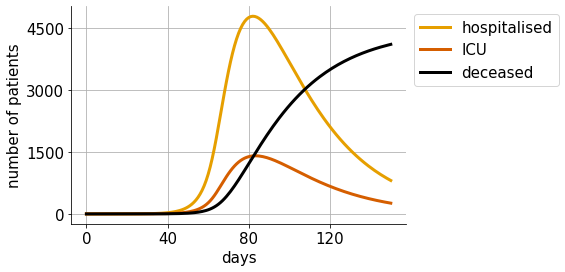

In [34]:
infected(out)

#### The simulation output includes evolution of  the age-stratified number of quality averaged life-years lost

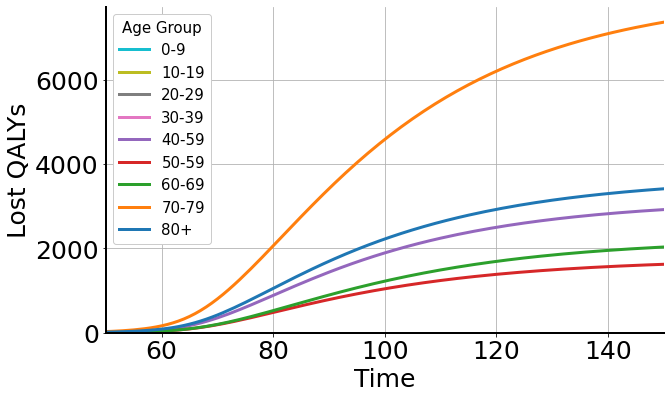

In [35]:
#Plot

Palette=cm.get_cmap('tab10_r', levels).colors
age_group=['0-9','10-19','20-29','30-39','40-59','50-59','60-69','70-79','80+']

fig, ax = plt.subplots(figsize=(10,6))

for i in range(levels):
               
    ax.plot(out['QALYs_lost'][i],linewidth=3, label=age_group[i],color=Palette[i])
    
#ax.plot(out['QALYs_lost'].sum(dim='Nc'),color='k',linewidth=4,label='Total')

ax.set_xlim(left=50,right=sim_time)
ax.set_ylim(bottom=0)
ax.set_xlabel('Time',fontsize=25)
ax.set_ylabel('Lost QALYs',fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=25)
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.set_axisbelow(True)
ax.legend(loc='best', fancybox=True, frameon=True, framealpha=1, fontsize=15,title='Age Group')  


 #####  Investigating the effect of  a reduction in regular hospital care on the loss of life is possible.
+ In the folowing example, the loss of life due to a constant average percentual reduction in regular hospital is calculated and compared with the overall loss of life to Covid-19.
+ The provided function can be used to investigate the effect of time-dependent changes in hospital care as well as reductions in the treatment of different disease categories.

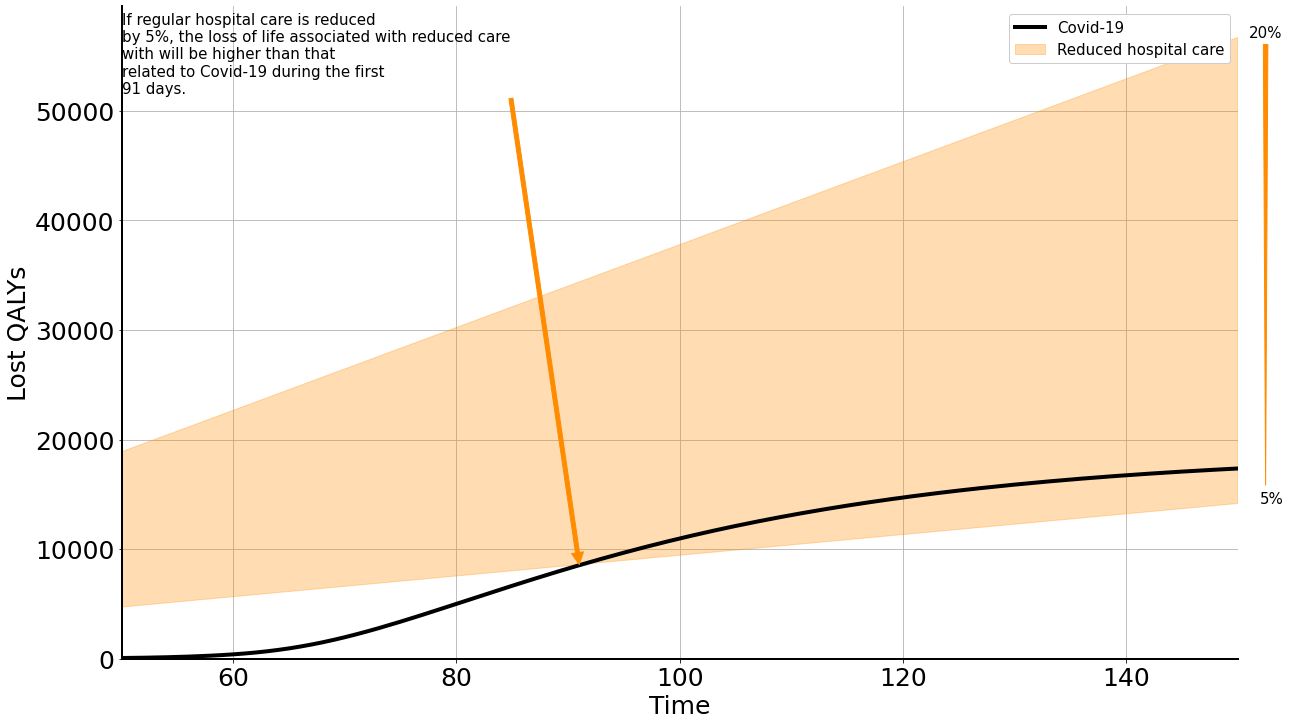

In [41]:
from covid19model.models.QALY import lost_QALY_hospital_care

#Define percentual reduction range
reduction_range=np.linspace(0.05,0.2,200)
#Calculate QALYs lost due to hospital care reduction
#The function output is annualized
lost_hospital=lost_QALY_hospital_care(reduction_range)/365
#Convert results into time series
lost_hospital_time=np.zeros((lost_hospital.size,sim_time+1))
time=np.array(out['QALYs_lost']['time'])
for i in range(sim_time+1):     
    lost_hospital_time[:,i]=time[i]*lost_hospital
    
#Plot
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(out['QALYs_lost'].sum(dim='Nc'),color='k',linewidth=4,label='Covid-19')
ax.fill_between(time, lost_hospital_time[0,:], lost_hospital_time[-1,:],color='darkorange',
            alpha=0.3,label='Reduced hospital care')

ax.set_xlim(left=50,right=sim_time)
ax.set_ylim(bottom=0)

arrow_limit_upper=trans = (ax.transData + ax.transAxes.inverted()).transform((1,lost_hospital_time[-1,-1]))
arrow_limit_lower=trans = (ax.transData + ax.transAxes.inverted()).transform((1,lost_hospital_time[0,-1]))
ax.annotate("{0}%".format(int(reduction_range[-1]*100)), xy=(1.025, arrow_limit_lower[1]+0.025), 
            xycoords='axes fraction', xytext=(1.01, arrow_limit_upper[1]), 
            arrowprops=dict(arrowstyle="wedge", color='darkorange'))

ax.text(1.02,arrow_limit_lower[1],"{0}%".format(int(reduction_range[0]*100)),transform=ax.transAxes)
#Calculate interection point
Intersect_point=np.argwhere(np.diff(np.sign(out['QALYs_lost'].sum(dim='Nc') - lost_hospital_time[0,:]))).flatten()
ax.annotate(("If regular hospital care is reduced\nby {0}%, the loss of life associated with reduced care"  
            "\nwith will be higher than that\nrelated "
            "to Covid-19 during the first\n{1} days.").format(int(reduction_range[0]*100),time[Intersect_point[1]]), 
            xy=(time[Intersect_point[1]], lost_hospital_time[0,Intersect_point[1]]), 
            xytext=(0.55*time[Intersect_point[1]], 1.5*lost_hospital_time[-1,Intersect_point[1]]), 
            arrowprops=dict(color='darkorange'))

ax.set_xlabel('Time',fontsize=25)
ax.set_ylabel('Lost QALYs',fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=25)
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.set_axisbelow(True)
ax.legend(loc='best', fancybox=True, frameon=True, framealpha=1, fontsize=15)  